# **Exploratory Data Analysis**

This notebook contains visualizations to help understand the underlying data, noting differences between patients that survived / died.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import random

In [2]:
sns.set_style('darkgrid')
%matplotlib inline
%config InlineBackend.figure_format = 'retina' #set figures to display in higher res
sns.set_context('talk')

# set palette so survivors = blue, non-survivors = red
colors = ['#3b5b92', '#d9544d', '#06470c']
sns.set_palette(sns.color_palette(colors))

In [3]:
# import general descriptors 
filepath = os.path.join('.', 'data', 'interim', 'set-a_general-descriptors.csv')
df_gen_desc = pd.read_csv(filepath)

# import timeseries data
filepath = os.path.join('.', 'data', 'interim', 'set-a_timeseries.csv')
df_ts = pd.read_csv(filepath)

# import outcomes data
filepath = os.path.join('.', 'data', 'raw', 'Outcomes-a.txt')
df_outcomes = pd.read_csv(filepath)

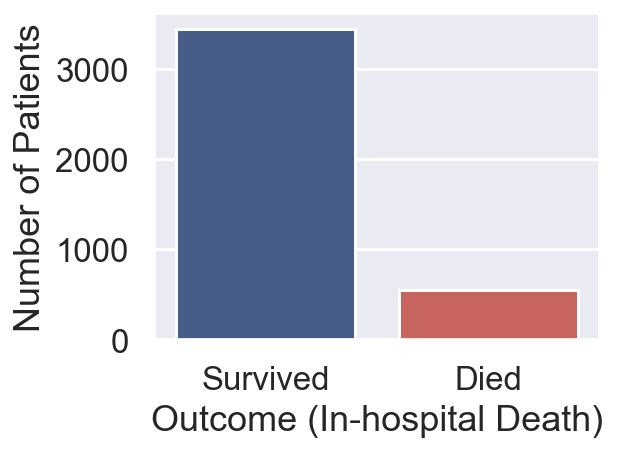

In [4]:
# Plot distribution of outcomes
fig, ax = plt.subplots(figsize=(4,3))
ax = sns.countplot(
    np.where(df_outcomes['In-hospital_death']>0, 'Died', 'Survived')
)
ax.set(ylabel='Number of Patients', xlabel='Outcome (In-hospital Death)')
plt.show()

In [5]:
df_outcomes['In-hospital_death'].value_counts()

0    3446
1     554
Name: In-hospital_death, dtype: int64

It's clear our classes are very imbalanced, with only 554 deaths compared to 3446 survivors.

In [6]:
# merge general descriptors and timeseries data with outcomes for visualization
df_gen_desc_outcomes = pd.merge(df_gen_desc, df_outcomes, how='left', on='RecordID')
df_ts_outcomes = pd.merge(df_ts, df_outcomes, how='left', on='RecordID')

In [7]:
# define function to label facetgrid legends
def label_legend(g):
    g.add_legend()
    labels = ['Survived', 'Died']
    for text, label in zip(g._legend.texts, labels): 
        text.set_text(label)
    return g

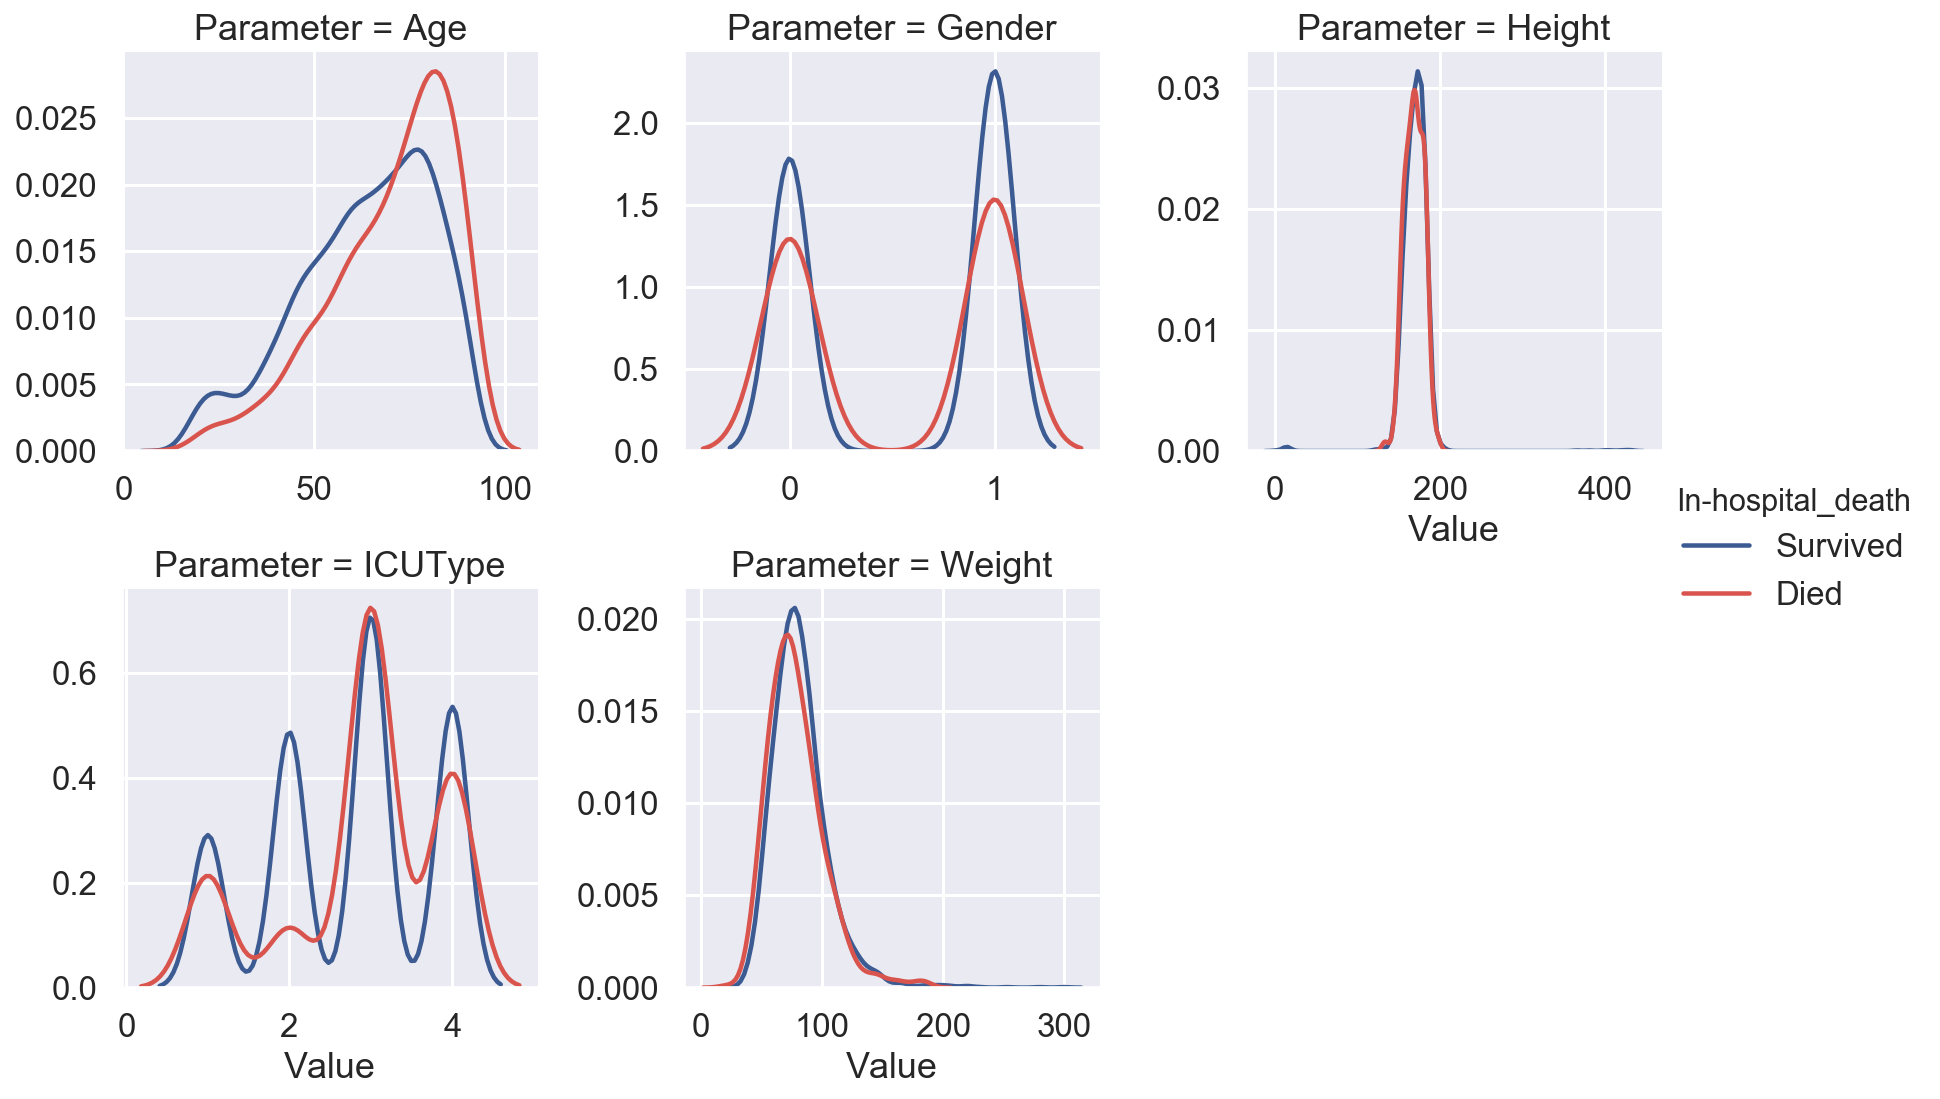

In [8]:
g = sns.FacetGrid(df_gen_desc_outcomes, col='Parameter', hue='In-hospital_death',
                  col_wrap = 3, height = 4, aspect = 1, sharey=False, sharex=False)
g.map(sns.kdeplot, 'Value')
label_legend(g)
plt.show()

Those who died tend to be older, weigh less, and have been treated in ICUType = 2 less often. (1: Coronary Care Unit, 2: Cardiac Surgery Recovery Unit, 3: Medical ICU, or 4: Surgical ICU)

In [9]:
# Define helper function to create consistent facetgrids
def make_survival_facet_grid(df, col_wrap=4, height=4, aspect=1, sharey=False, sharex=False):
    fg = sns.FacetGrid(df, col='Parameter', hue='In-hospital_death',
                      col_wrap = col_wrap, height = height, aspect = aspect,
                      sharey=sharey, sharex=sharex)
    return fg

In [10]:
# Create dataframe for drawing KDE plots that filters out MechVent. 
# It only has one value, so it prevents KDE plots from being drawn
df_for_kde = df_ts_outcomes.loc[df_ts_outcomes['Parameter']!='MechVent', :]

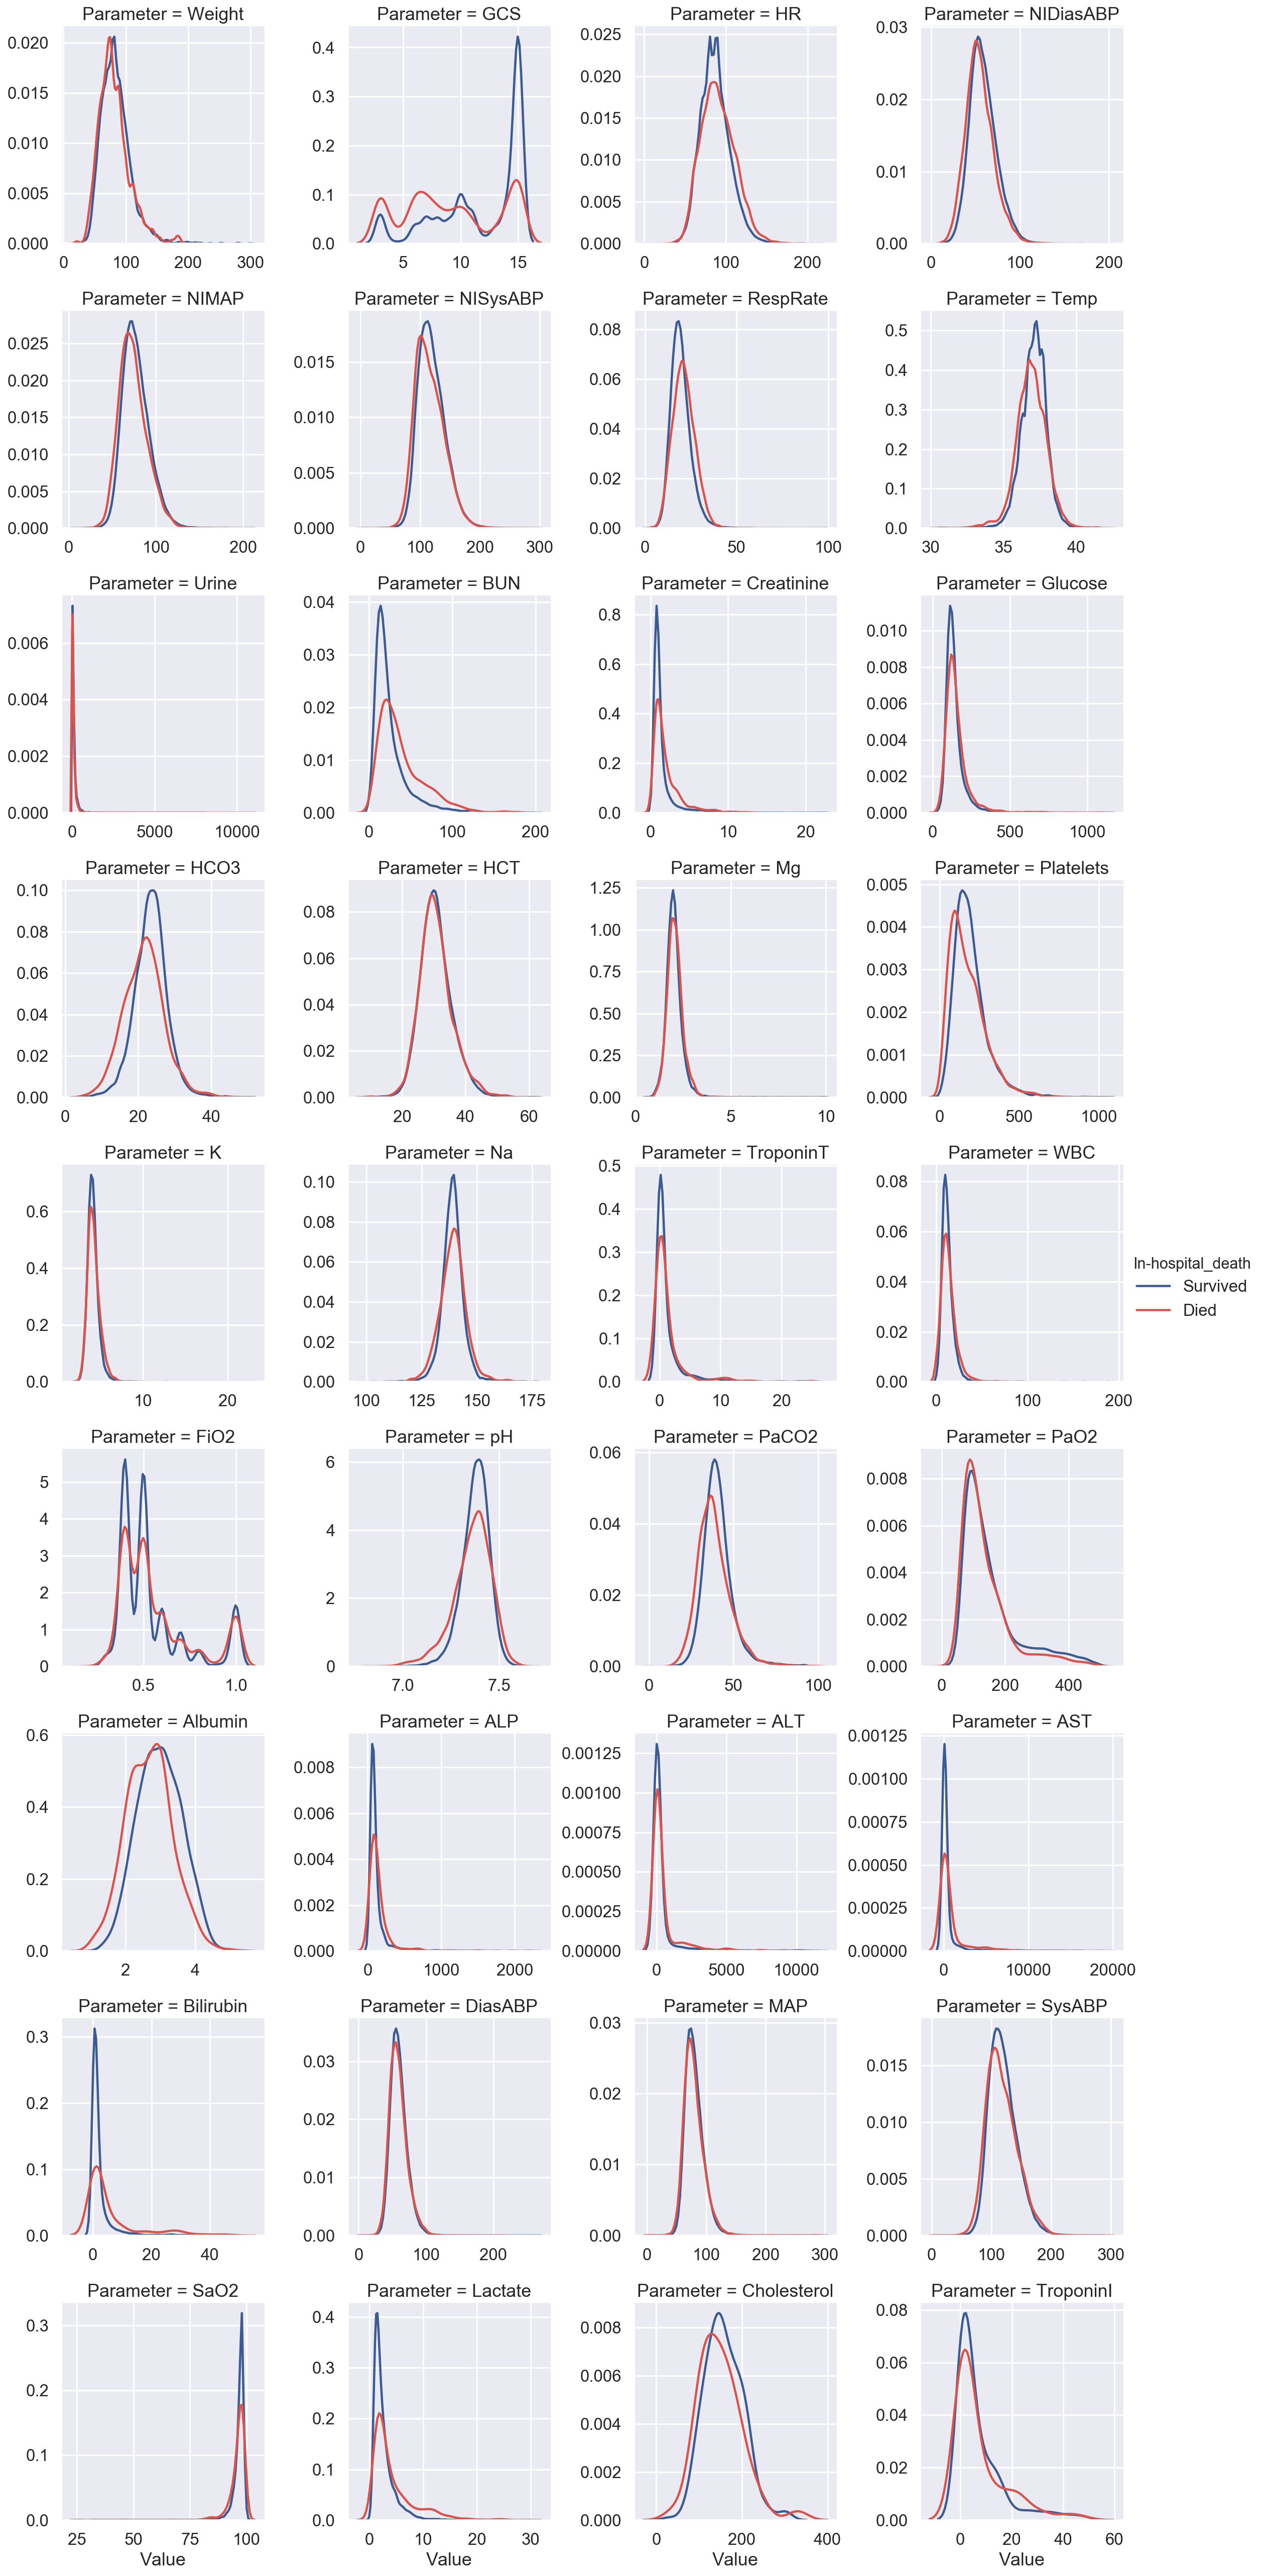

In [11]:
# make facet grid of parameter distributions by survival 
g = make_survival_facet_grid(df_for_kde)
g.map(sns.kdeplot, 'Value')
g = label_legend(g)
plt.show()

Patients who died tend to have lower:
* GCS
* HCO3
* Platelets
* PaCO2
* Albumin
* Cholesterol

and higher:
* Lactate
* Creatinine
* BUN
* Heart Rate

It's clear that there are outliers in many of these distributions, so let's try removing them to improve visualization. Furthermore, many of the distributions are skewed so let's transform them so we can better visualize distributions.

In [12]:
def remove_values(df, param, below=None, above=None):
    if below is not None:
        df.loc[(df['Parameter']==param) & (df['Value']<below), 'Value'] = np.nan
    if above is not None:
        df.loc[(df['Parameter']==param) & (df['Value']>above), 'Value'] = np.nan    
    return df

df_ts_outcomes = remove_values(df_ts_outcomes, 'Urine', above=3000)
df_ts_outcomes = remove_values(df_ts_outcomes, 'SaO2', below=75)
df_ts_outcomes = remove_values(df_ts_outcomes, 'MAP', above=200)
df_ts_outcomes = remove_values(df_ts_outcomes, 'AST', above=10000)
df_ts_outcomes = remove_values(df_ts_outcomes, 'ALT', above=7500)
df_ts_outcomes = remove_values(df_ts_outcomes, 'K', above=10)
df_ts_outcomes = remove_values(df_ts_outcomes, 'WBC', above=100)
df_ts_outcomes = remove_values(df_ts_outcomes, 'RespRate', above=75)

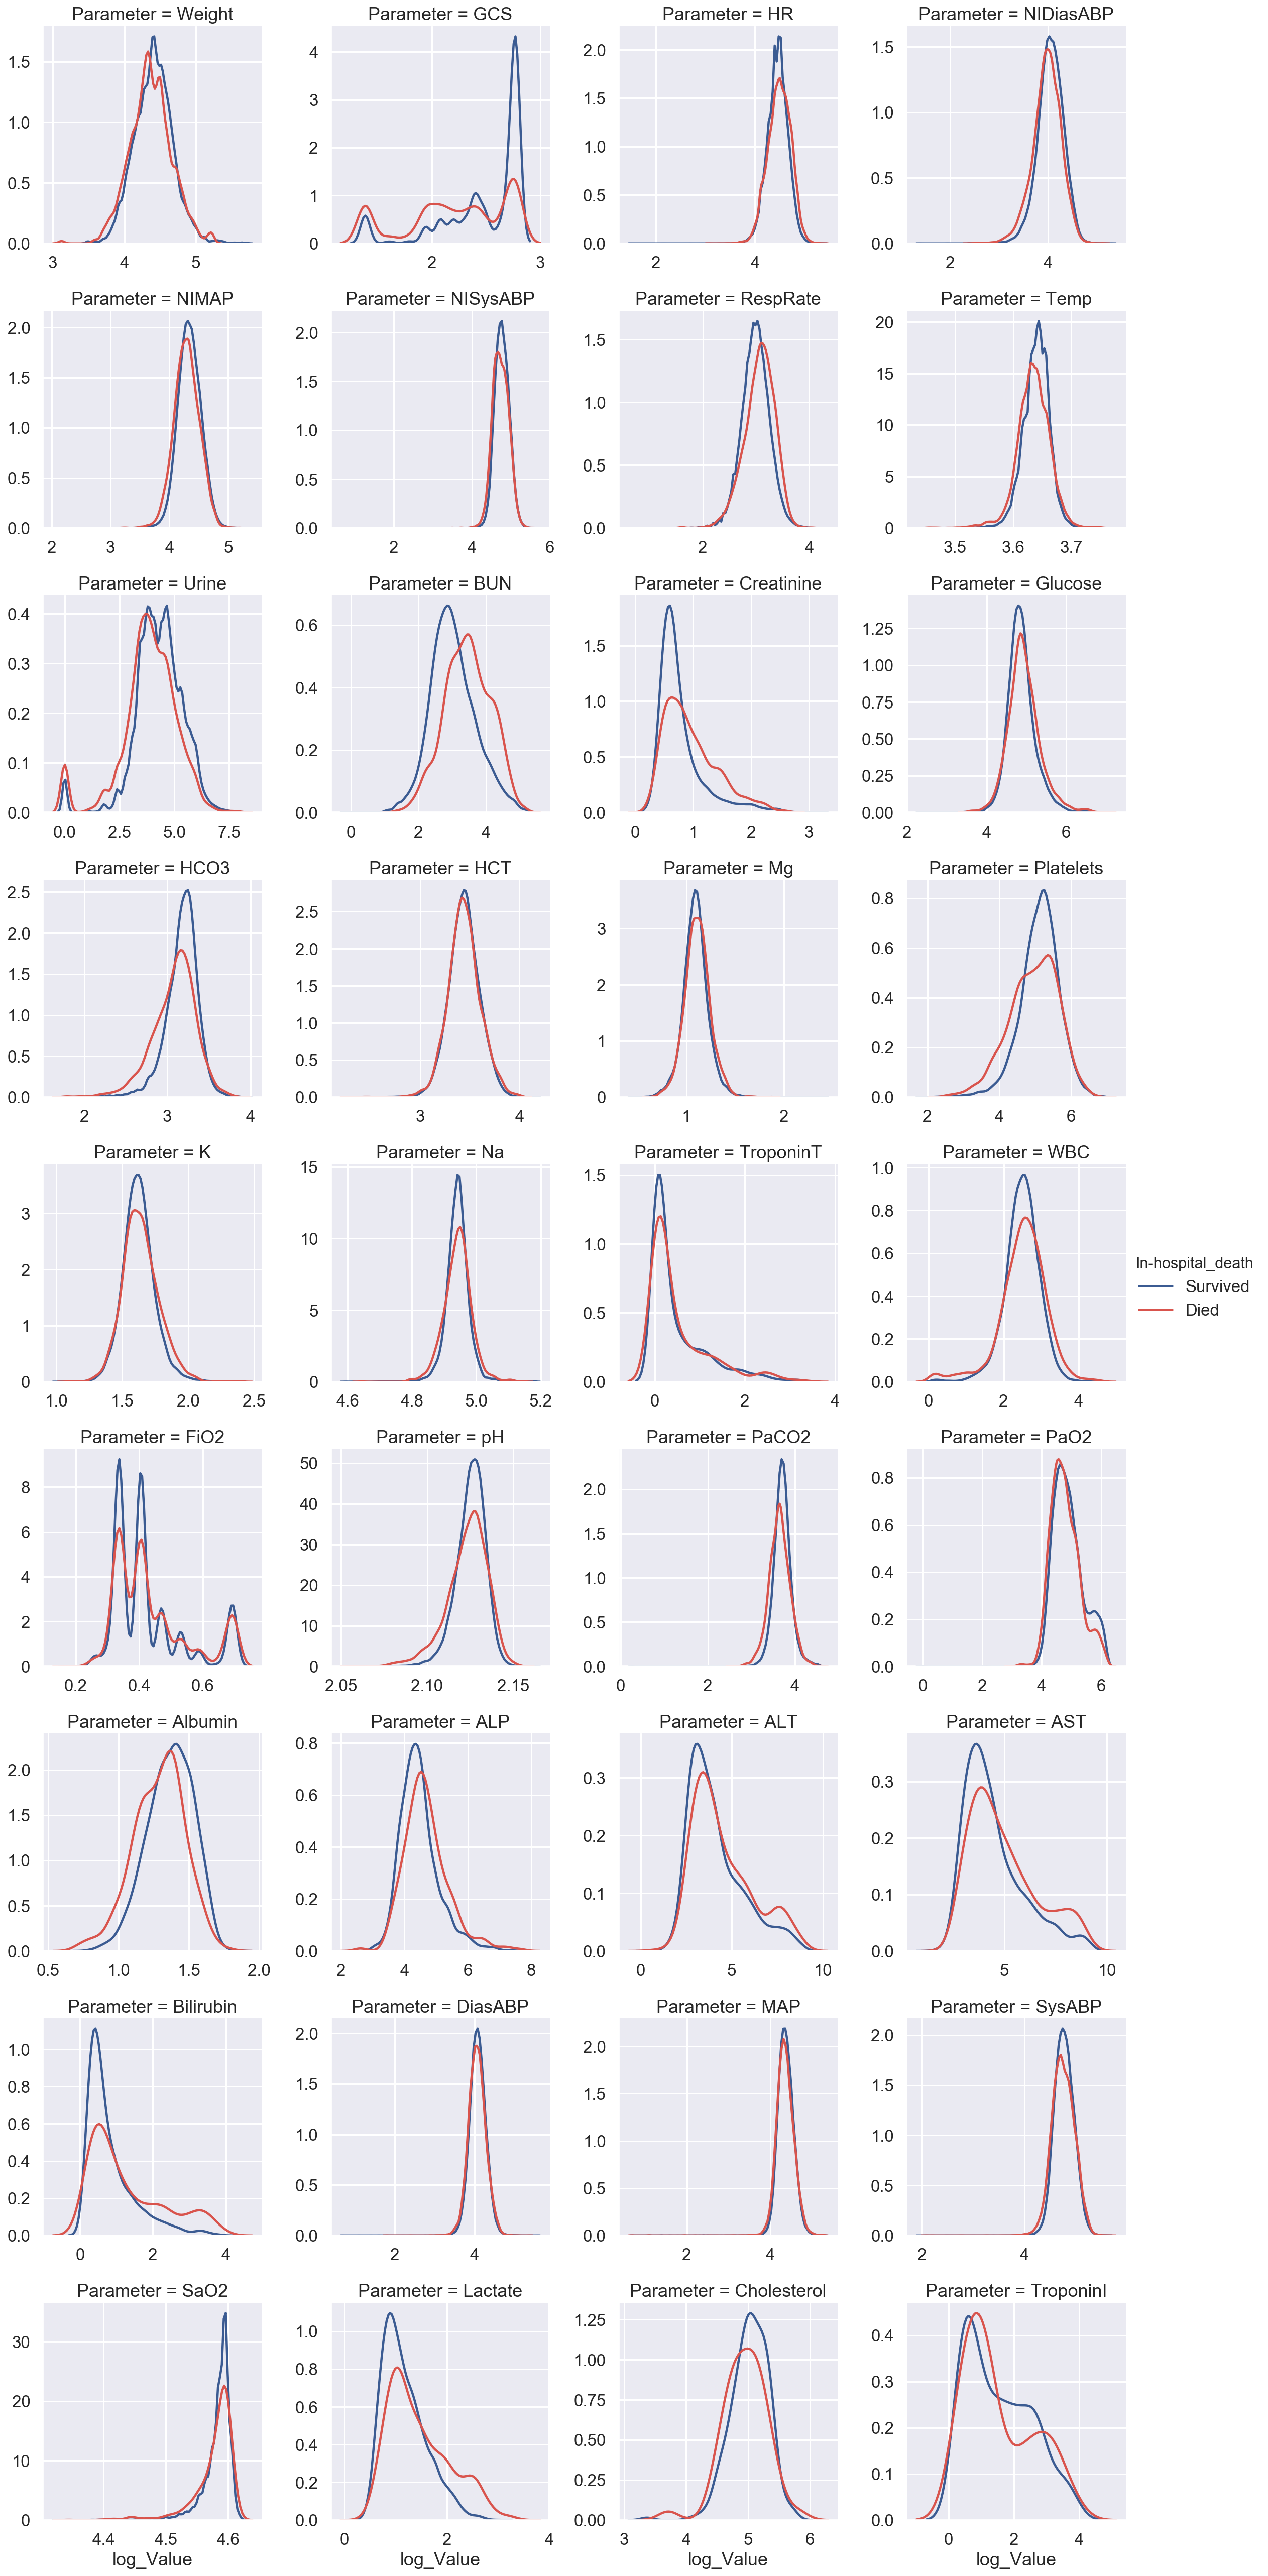

In [13]:
# create log_value and sqrt_Value columns to help visualize parameters with skewed values
df_ts_outcomes['log_Value'] = df_ts_outcomes['Value'].apply(lambda x: np.log(x+1))

df_for_kde = df_ts_outcomes.loc[df_ts_outcomes['Parameter']!='MechVent', :]

g = make_survival_facet_grid(df_for_kde)
g.map(sns.kdeplot, 'log_Value')
g = label_legend(g)
plt.show()

From the transformed chart with outliers removed, we can more clearly see a differences between classes in AST, ALT, ALP, RespRate, and Urine. From these distributions, it's clear that the mean value for some of these parameters can help predict mortality.

We should also look at how these values change over time, and if those trends are different for each class. Let's start with linear trends.

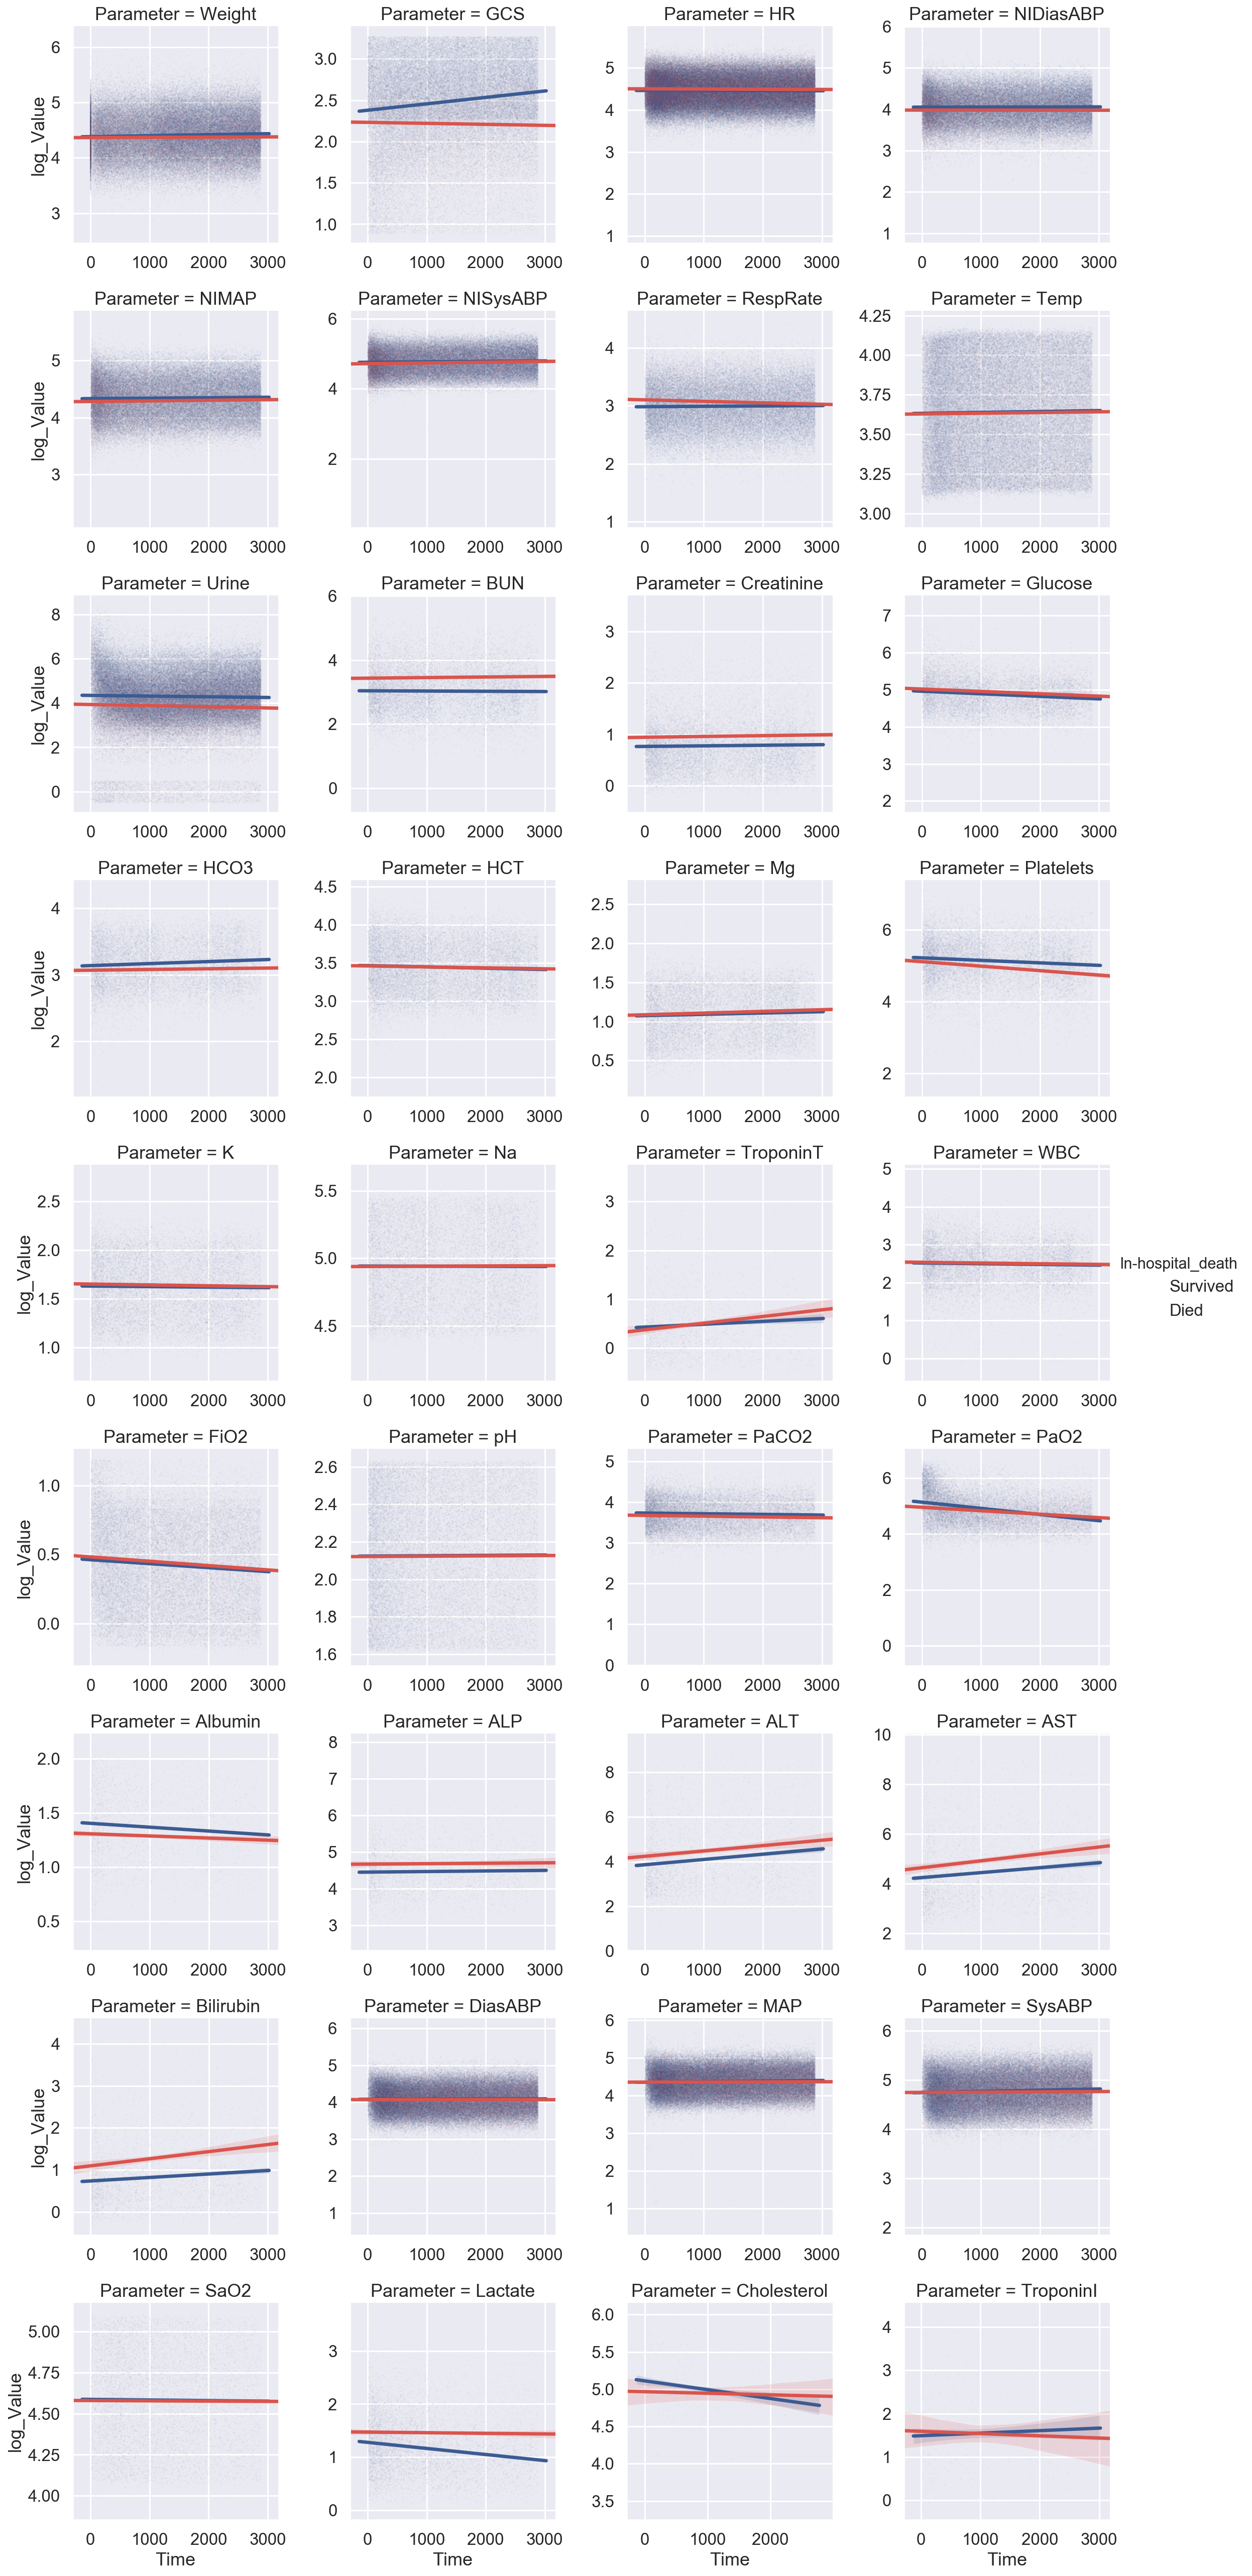

In [14]:
g = make_survival_facet_grid(df_for_kde)
g.map(sns.regplot, 'Time', 'log_Value', scatter=True, 
      y_jitter = .5, scatter_kws={'alpha':.03, 's':.3})
g = label_legend(g)
plt.show()

From the plots of values over time, we can see some differences in slope for a few parameters, notably, GCS, Lactate, Bilirubin, and Albumin. From these findings, it makes sense to include the slope of how each parameter changes over time in our feature engineering.

The code below plots the parameters values over time for a random patient who survived and a random patient who died. I find that seeing patient journeys individually helps provide a clearer picture for some of the differences between those who survived / died.

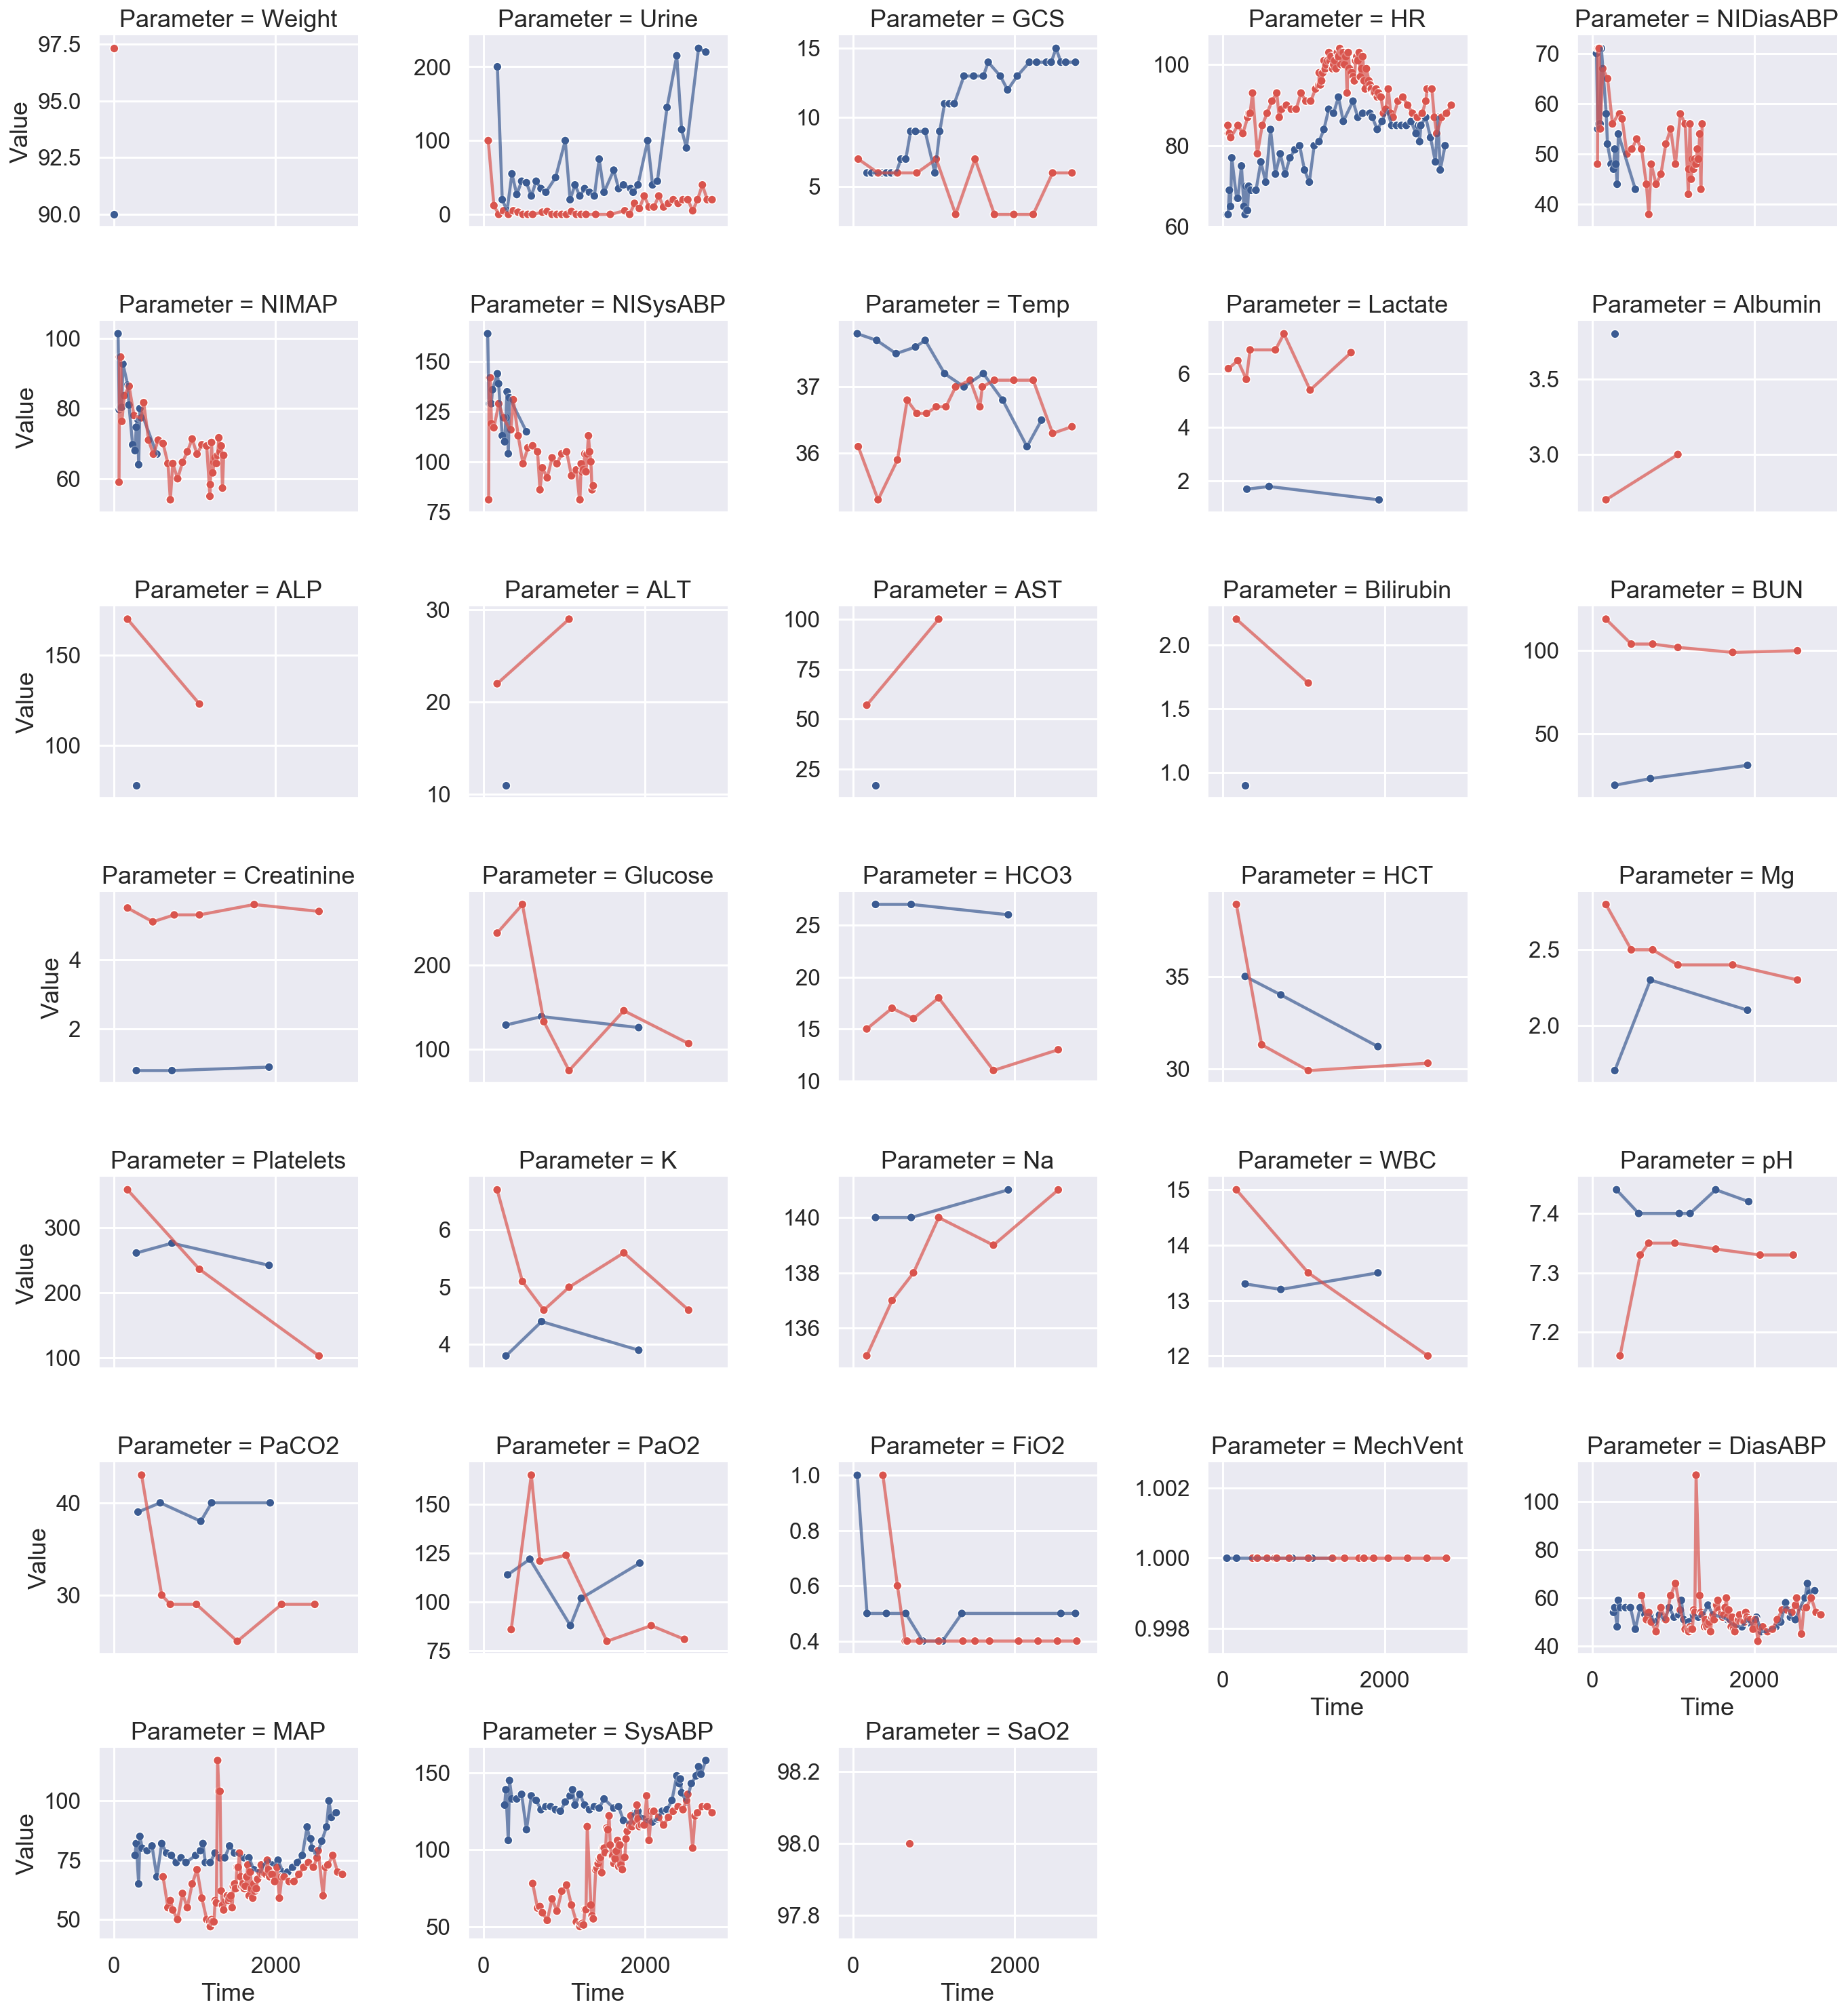

In [27]:
# get one random survivor and death and filter timeseries dataframe for these 2 patients: patients_to_plot
survivor_id = random.choice(list(df_ts_outcomes.loc[df_ts_outcomes['In-hospital_death']==0, 'RecordID'].unique()))
death_id = random.choice(list(df_ts_outcomes.loc[df_ts_outcomes['In-hospital_death']==1, 'RecordID'].unique()))
patients_to_plot = df_ts_outcomes.loc[df_ts_outcomes['RecordID'].isin([survivor_id, death_id]),:]

# plot values of parameters over time
fg = make_survival_facet_grid(patients_to_plot, col_wrap = 5, height = 3, aspect=1.3, sharex=True)
fg.map(sns.lineplot, 'Time', 'Value', ci=False, alpha=.7)
fg.map(sns.scatterplot, 'Time', 'Value', size=1)
plt.show()